In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import ExactGPModel
from bo_functions import test_train_split
from bo_functions import bo_iter
from bo_functions import bo_iter_w_runs


import matplotlib as mpl

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 2
train_iter = 300
noise_std = 0.1
runs = 1

emulator = False
sparse_grid = False
verbose = True
save_fig=False

shuffle_seed = 6
# set_lengthscale = None
set_lengthscale = np.array([None])
t=4
mpl.rcParams['figure.dpi'] = 82

# explore_bias = torch.tensor([0,0.1,0.5])
explore_bias = torch.tensor([0.75])

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(0.5,1.5,p) #1x10
Theta2 =  np.linspace(-1.5,-0.5,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

Runs: 1
BO Iters: 2
------------------------------
Lengthscale Set To: [None]
Explore Bias: tensor(0.7500)
Run Number:  1


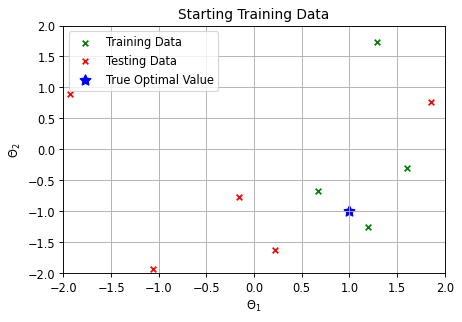

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


BO Iteration =  1
Jasrasaria EP: tensor(0.7500)
Boyle EP: tensor(0.7500)
Exp EP: tensor(0.7500)
Exploration Bias =  tensor(0.7500)
Scipy Theta Best =  [-0.13577435 -2.        ]
Argmax Theta Best =  [-1.36842105 -2.        ]
Scipy Theta Opt =  [ 0.46327602 -2.        ]
Argmin Theta_Opt_GP =  [ 0.52631579 -2.        ] 



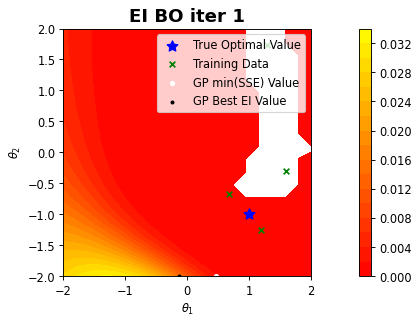

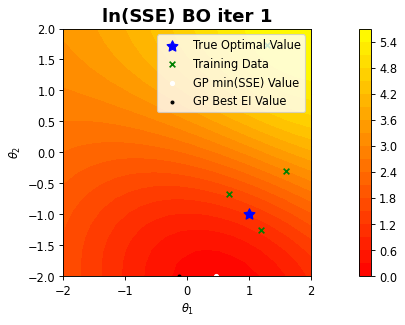

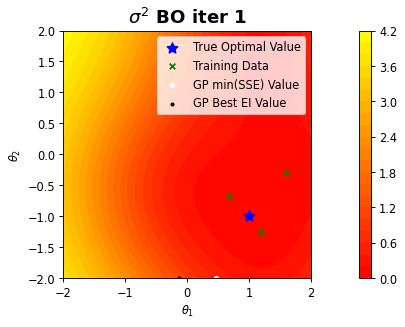

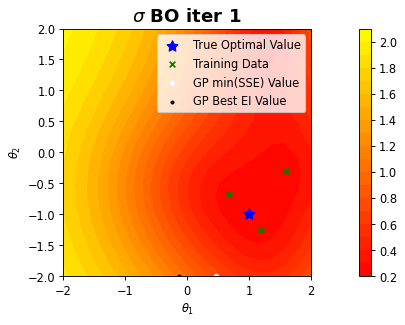

Best Error is: 0.9352


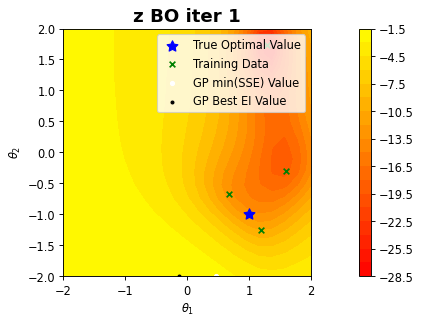

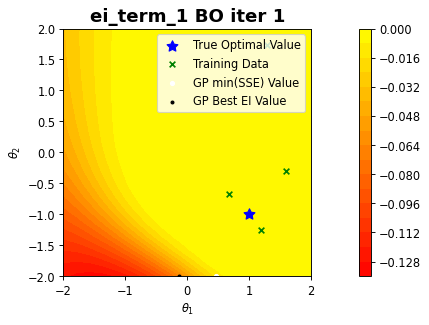

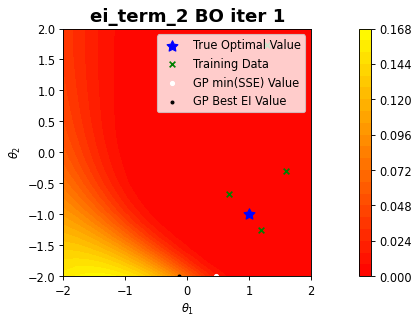

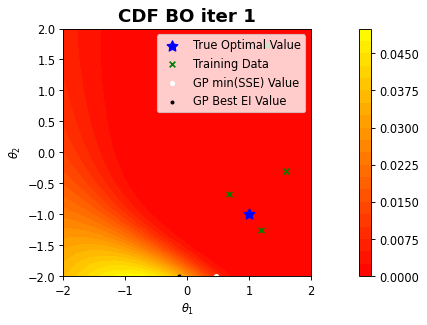

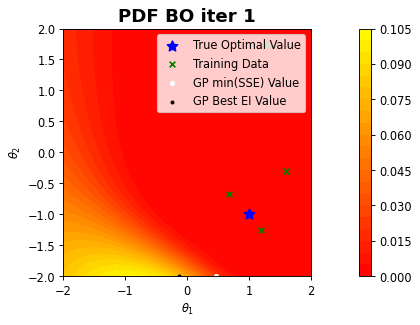

Magnitude of ln(SSE) given Theta_Opt =  [ 0.46327602 -2.        ] is 3.5998e+00
BO Iteration =  2
Jasrasaria EP: 1.8108470418595057
Boyle EP: tensor(0.9742)
Exp EP: tensor(0.6495)
Exploration Bias =  tensor(0.6495)
Scipy Theta Best =  [ 1.65745607 -1.87485536]
Argmax Theta Best =  [ 2. -2.]
Scipy Theta Opt =  [ 1.06925004 -1.19300331]
Argmin Theta_Opt_GP =  [ 1.15789474 -1.15789474] 



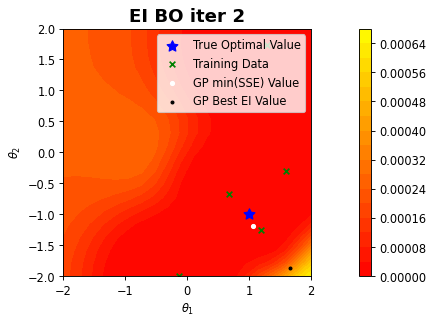

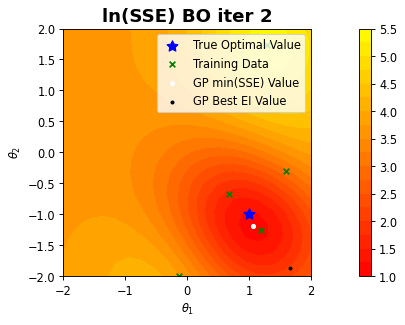

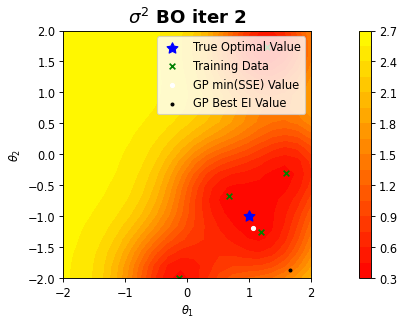

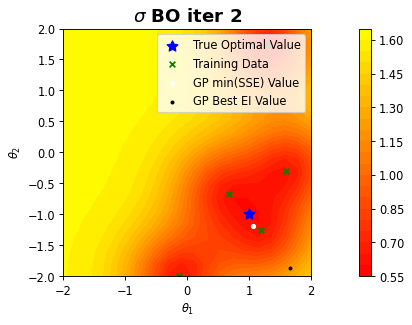

Best Error is: 0.9352


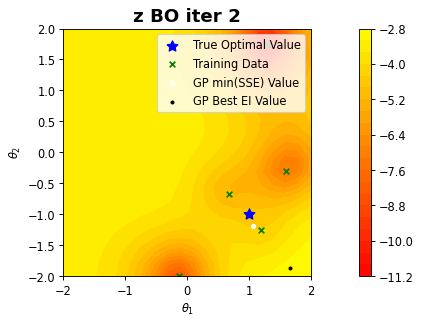

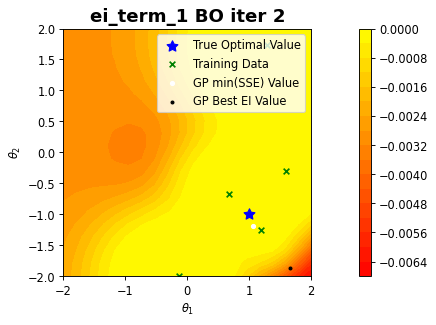

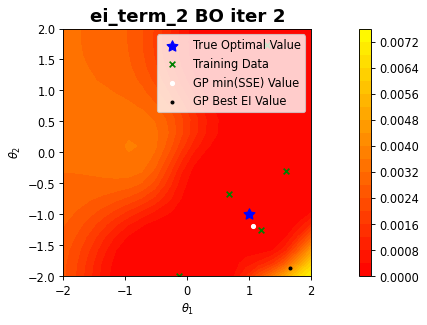

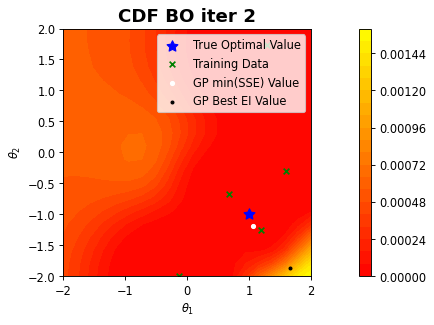

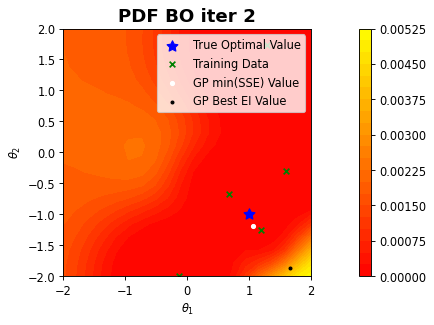

Magnitude of ln(SSE) given Theta_Opt =  [ 1.06925004 -1.19300331] is 2.4658e-01


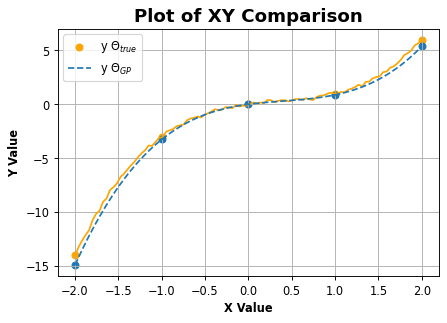

The GP predicts the lowest SSE of 1.280e+00 occurs at θ = [ 1.06925004 -1.19300331] during Run 1 at BO iteration 2
At this point, the highest EI occurs at θ = [ 1.65745607 -1.87485536]
CPU times: user 8.47 s, sys: 187 ms, total: 8.66 s
Wall time: 8.68 s


In [3]:
%%time

obj = "LN_obj"        

all_data_doc = "Input_CSVs/Train_Data/all_2_ln_obj_data/t=25.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   
print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")
for i in range(len(set_lengthscale)):
    for j in range(len(explore_bias)):
        print("Lengthscale Set To:", set_lengthscale)
        print("Explore Bias:", explore_bias[j])
        results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[j], Xexp, Yexp,
                                     noise_std, obj, runs, sparse_grid, emulator, set_lengthscale[i], verbose,save_fig, 
                                     shuffle_seed)
        print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
              "during Run", results[1], "at BO iteration", results[0])
        print("At this point, the highest EI occurs at \u03B8 =", results[4][0])